Configurar matplotlib para ver las gráficas en linea

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from niwidgets import NiftiWidget
import ipywidgets as widgets
from nilearn import (image, plotting)
from nilearn.image.image import mean_img,load_img,index_img
from nilearn.input_data import NiftiMasker,NiftiLabelsMasker,NiftiMapsMasker
import os

In [2]:
results_path = "../../../02-RESULTADOS/output/preproc/"
dirs = next(os.walk(results_path))[1]
list_subjs = list(filter(lambda dir: "session" in dir,dirs))
len(list_subjs)

111

In [3]:
subj_id_selector = widgets.Select(
    options=list_subjs,
    # value='C575',
    # rows=10,
    description='Subject Id:',
    disabled=False
)
#subj_id_selector.on_trait_change(run_cells_below)
display(subj_id_selector)

Select(description='Subject Id:', options=('_session_id_1_subject_id_C021', '_session_id_1_subject_id_C024', '…

Lazy load del atlas y del archivo de neuroimagen para probar el atlas

In [4]:
fmri_root = "../../../00-DATASOURCES/00-FMRI/"
fsl_prob_cerebelo = fmri_root+"/TEMPLATES/Cerebellum-MNIfnirt-prob-2mm.nii.gz"
fsl_prob_cerebelo_3d = fmri_root+"/TEMPLATES/Cerebellum-MNIflirt-maxprob-thr0-1mm.nii.gz"
func_filenames = results_path+subj_id_selector.value+"/applyTransFunc/f1_trim_st_mcf_trans.nii.gz"
mni_template = fmri_root+"/TEMPLATES/MNI152_T1_3mm.nii.gz"
func_filenames

'../../../02-RESULTADOS/output/preproc/_session_id_1_subject_id_C045/applyTransFunc/f1_trim_st_mcf_trans.nii.gz'

NiftiMapsMasker para extraer las señales del cerebelo. NiftiMapsMasker es útil cuando se deben extraer datos de volúmenes superpuestos 

In [5]:
cbl_img = fsl_prob_cerebelo
masker = NiftiMapsMasker(maps_img=cbl_img, memory='nilearn_cache', verbose=True)
#masker = NiftiLabelsMasker(labels_img=cbl_img, memory='nilearn_cache', verbose=True)
#masker = NiftiMasker(mask_img=cbl_img, memory='nilearn_cache', verbose=True)#Needs binary mask

C:\Users\isancmen\AppData\Local\Continuum\anaconda3\envs\pyrestfmri\lib\site-packages\nilearn\plotting\displays.py:98: UserWarning: No contour levels were found within the data range.
  **kwargs)
C:\Users\isancmen\AppData\Local\Continuum\anaconda3\envs\pyrestfmri\lib\site-packages\numpy\ma\core.py:2788: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
C:\Users\isancmen\AppData\Local\Continuum\anaconda3\envs\pyrestfmri\lib\site-packages\nilearn\plotting\displays.py:98: UserWarning: linewidths is ignored by contourf
  **kwargs)


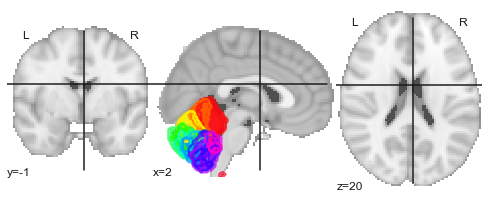

In [6]:
plotting.plot_prob_atlas(cbl_img, view_type='filled_contours')

Entrenamiento del modelo para aplicar la extracción del cerebelo

In [7]:
masker.fit()

[NiftiMapsMasker.fit] loading regions from ../../../00-DATASOURCES/00-FMRI//TEMPLATES/Cerebellum-MNIfnirt-prob-2mm.nii.gz


NiftiMapsMasker(allow_overlap=True, detrend=False, dtype=None, high_pass=None,
        low_pass=None,
        maps_img='../../../00-DATASOURCES/00-FMRI//TEMPLATES/Cerebellum-MNIfnirt-prob-2mm.nii.gz',
        mask_img=None, memory='nilearn_cache', memory_level=0,
        resampling_target='data', smoothing_fwhm=None, standardize=False,
        t_r=None, verbose=True)

Extracción de las series temporales dado el atlas de probabilidad del cerebelo a partir de las imágenes fmri.

In [ ]:
timeseries_subject = masker.transform(func_filenames, confounds=None)

Resampling maps


C:\Users\isancmen\AppData\Local\Continuum\anaconda3\envs\pyrestfmri\lib\site-packages\nilearn\_utils\cache_mixin.py:302: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "
C:\Users\isancmen\AppData\Local\Continuum\anaconda3\envs\pyrestfmri\lib\site-packages\nilearn\_utils\cache_mixin.py:129: UserWarning: Incompatible cache in nilearn_cache\joblib: different version of nibabel. Deleting the cache. Put nilearn.CHECK_CACHE_VERSION to false to avoid this behavior.
  % cachedir)


________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x0000018F36A67AC8>, interpolation='continuous', target_shape=(61, 73, 61), target_affine=array([[  -3.,    0.,    0.,   90.],
       [   0.,    3.,    0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]]))


Gráfica de las 28 series temporales extraidas

In [ ]:
fig = plt.figure()
plt.plot(timeseries_subject)
plt.xlabel('Volume')
plt.ylabel('Pixel value')
plt.show()

In [102]:
len(timeseries_subject[0])

28

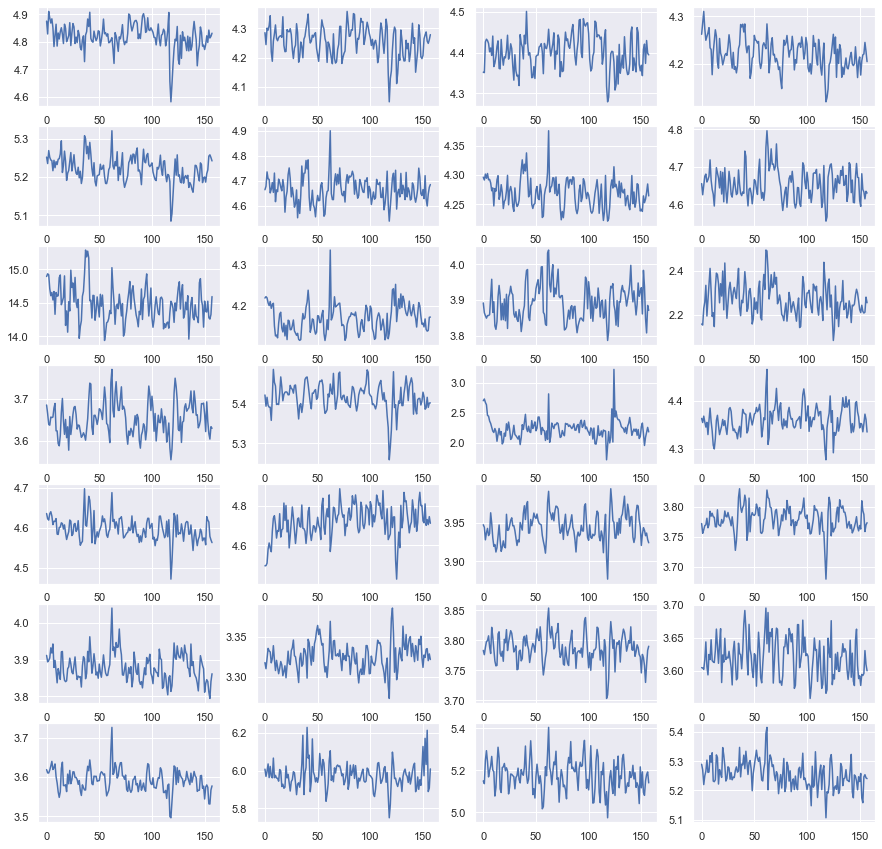

In [166]:
from matplotlib import cm

plt.figure(figsize=(15.,15.))
for i,ts in enumerate(timeseries_subject.T):
    plt.subplot(7, 4, i+1)
    plt.plot(ts, label=i+1)

In [12]:
timeseries_subject.shape

(158, 28)

In [13]:
cbl_subject = masker.inverse_transform(timeseries_subject)

[NiftiMapsMasker.inverse_transform] computing image from signals


In [14]:
print(cbl_subject)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91, 158)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  91 109  91 158   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code

In [15]:
cbl_widget = NiftiWidget(cbl_subject)
cbl_widget.nifti_plotter()

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=45, continuous_update=False, description='x', max=90), IntSlider(value=5…